In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from src.constant import LABELS
from src.preprocess import process_label

plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata = metadata.group_by("eeg_id").agg(
    *[
        pl.col(f"{label}_prob_per_eeg").first().alias(f"gt_{label}_prob")
        for label in LABELS
    ],
    pl.col("weight_per_eeg").first().alias("weight"),
)

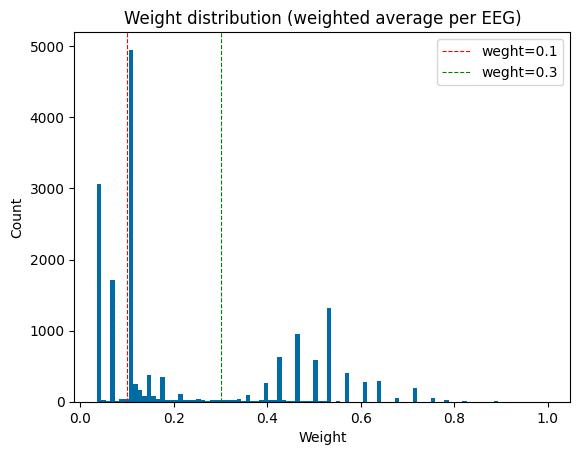

In [16]:
_, ax = plt.subplots()

ax.hist(metadata["weight"].to_numpy(), bins=100)
ax.set(
    xlabel="Weight",
    ylabel="Count",
    title="Weight distribution (weighted average per EEG)",
)
ax.axvline(0.1, color="red", linestyle="--", label="weght=0.1", linewidth=0.8)
ax.axvline(0.3, color="green", linestyle="--", label="weght=0.3", linewidth=0.8)
ax.legend()
plt.show()

In [10]:
eeg_ids_very_low_quality = metadata.filter(pl.col("weight") < 0.1)["eeg_id"].to_numpy()
eeg_ids_low_quality = metadata.filter(
    (pl.col("weight") >= 0.1) & (pl.col("weight") < 0.3)
)["eeg_id"].to_numpy()
eeg_ids_high_quality = metadata.filter(pl.col("weight") >= 0.3)["eeg_id"].to_numpy()

In [13]:
print(f"very_low_quality: {eeg_ids_very_low_quality.shape[0]:,}")
print(f"low_quality: {eeg_ids_low_quality.shape[0]:,}")
print(f"high_quality: {eeg_ids_high_quality.shape[0]:,}")

very_low_quality: 4,875
low_quality: 6,689
high_quality: 5,525


In [17]:
output_dir = Path("/ml-docker/working/kaggle-hms-bilzard/data/eeg_id_per_quality")

if not output_dir.exists():
    output_dir.mkdir(parents=True)

np.save(output_dir / "very_low_quality.npy", eeg_ids_very_low_quality)
np.save(output_dir / "low_quality.npy", eeg_ids_low_quality)
np.save(output_dir / "high_quality.npy", eeg_ids_high_quality)